# 11 形态学操作

形态学操作包括: 膨胀 (dilation)、腐蚀 (erosion)、开操作 (opening)、闭操作 (closing).

以下形态学操作都是对于**二值化图像**而言的!!

## 腐蚀

对于**二值化图像**, 非黑即白. 假设背景是白色, 前景是黑色. 

若一个黑点上下左右4个点存在白色的, 则将该点也变成白的.

<br>

也可以类似定义其它的规则: 只要周围某几个像素中存在白色的, 则将该点也变成白色.  这就是腐蚀.


In [1]:
import numpy as np
def Erosion(img, pattern):
    """Erode an binary image with some pattern. Center of pattern should be 0 (black)."""
    N = pattern.shape[0] // 2
    img = img ^ 1
    img2 = np.pad(img, N, mode = 'constant', constant_values = 1)
    for i in range(pattern.shape[0]):
        for j in range(pattern.shape[1]):
            if pattern[i,j] == 0: # black
                # bitwise-and
                img &= img2[i:i+img.shape[0], j:j+img.shape[1]]
    img ^= 1
    return img

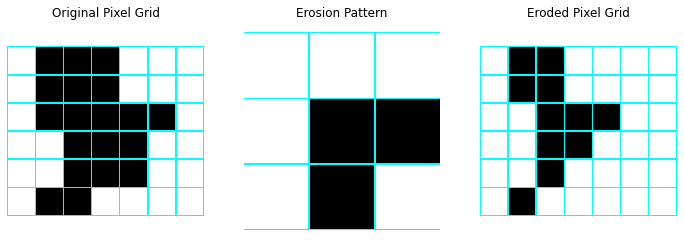

In [2]:
import numpy as np
from matplotlib import pyplot as plt

img = np.array([int(i) for i in bin(2458738291151)[2:]]).reshape((-1, 7))
pattern = np.array([[1,1,1],[1,0,0],[1,0,1]])
img_eroded = Erosion(img, pattern)

plt.figure(figsize = (12, 4))
for i, image, title in zip(range(1, 4), (img, pattern, img_eroded), \
        ('Original Pixel Grid', 'Erosion Pattern', 'Eroded Pixel Grid')):
    plt.subplot(1, 3, i)
    plt.pcolormesh(image[::-1,:], cmap = 'gray', edgecolors='aqua', linewidth=.5)
    plt.axis('equal')
    plt.axis('off')
    plt.title(title)
plt.show()

## 膨胀

腐蚀背景, 就是前景膨胀.

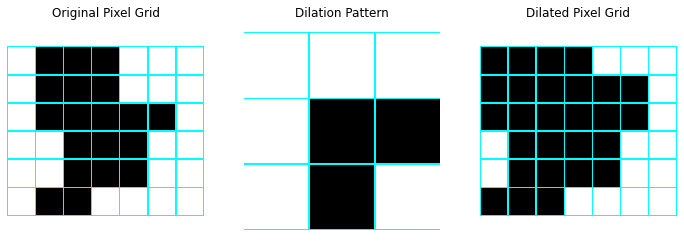

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def Dilation(img, pattern):
    return Erosion(img ^ 1, pattern) ^ 1

img = np.array([int(i) for i in bin(2458738291151)[2:]]).reshape((-1, 7))
pattern = np.array([[1,1,1],[1,0,0],[1,0,1]])
img_eroded = Dilation(img, pattern)

plt.figure(figsize = (12, 4))
for i, image, title in zip(range(1, 4), (img, pattern, img_eroded), \
        ('Original Pixel Grid', 'Dilation Pattern', 'Dilated Pixel Grid')):
    plt.subplot(1, 3, i)
    plt.pcolormesh(image[::-1,:], cmap = 'gray', edgecolors='aqua', linewidth=.5)
    plt.axis('equal')
    plt.axis('off')
    plt.title(title)
plt.show()

## 开操作

先腐蚀再膨胀. 

这样大多数点会因为膨胀而恢复原样, 但如果是孤立的噪点就会被腐蚀掉.

## 闭操作

先膨胀再腐蚀.

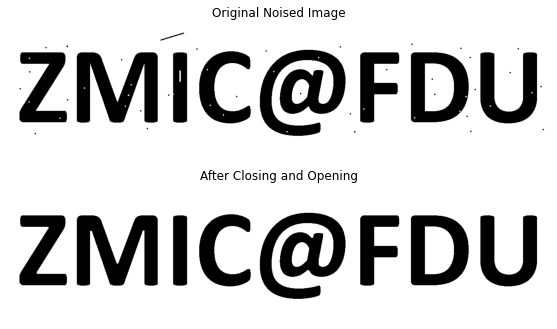

In [16]:
import os
from matplotlib import pyplot as plt
from PIL import Image 

def opening(img, pattern):
    return Dilation(Erosion(img, pattern), pattern)

def closing(img, pattern):
    return Erosion(Dilation(img, pattern), pattern)

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\zmic_fdu_noise.bmp')))
pattern = np.zeros((5, 5), dtype = 'bool')
img_processed = opening(closing(img, pattern), pattern) 
plt.figure(figsize = (10, 5.5))
for i, image, title in zip(range(1, 3), (img, img_processed),\
        ('Original Noised Image', 'After Closing and Opening')):
    plt.subplot(2, 1, i)
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.title(title)
plt.show()